## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.inspection import permutation_importance

In [2]:
data_contract = pd.read_csv('Downloads/final_provider/contract.csv')
data_personal = pd.read_csv('Downloads/final_provider/personal.csv')
data_internet = pd.read_csv('Downloads/final_provider/internet.csv')
data_phone = pd.read_csv('Downloads/final_provider/phone.csv')


warnings.filterwarnings('ignore')

In [3]:
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Данные загружены.У таблиц data_internet и data_phone данных(строк) меньше,это связано с тем что не все клиенты используют эти функции.

## Предобработка данных

In [11]:
#функция для замены значений в колонке target
def target_row(row):
    if row == 'No':
        return 1
    else:
        return 0
        
#функция для замены значений в колонке life        
def life(row):
    if row == 'No':
        return '2020-01-02 00:00:00'
    else:
        return row 

In [12]:
data_contract['target'] = data_contract['EndDate'].apply(target_row)
data_contract['EndDate'] = data_contract['EndDate'].apply(life)
#изменение типа данных в колонках BeginDate и EndDate
data_contract['BeginDate'] = pd.to_datetime(data_contract['BeginDate'], format='%Y-%m-%d %H:%M')
data_contract['EndDate'] = pd.to_datetime(data_contract['EndDate'], format='%Y-%m-%d %H:%M')
#вычисление временной дельты
data_contract['life'] = data_contract['EndDate'] - data_contract['BeginDate']

In [13]:
#создание единого датасета
intermediate_data_1 = pd.merge(data_contract, data_personal,
                        how="left", on=['customerID'])
intermediate_data_2 = pd.merge(data_phone, data_internet,
                        how="left", on=['customerID'])
data_ultimate = pd.merge(intermediate_data_1, intermediate_data_2,
                        how="left", on=['customerID'])

In [14]:
data_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerID        7043 non-null   object         
 1   BeginDate         7043 non-null   datetime64[ns] 
 2   EndDate           7043 non-null   datetime64[ns] 
 3   Type              7043 non-null   object         
 4   PaperlessBilling  7043 non-null   object         
 5   PaymentMethod     7043 non-null   object         
 6   MonthlyCharges    7043 non-null   float64        
 7   TotalCharges      7043 non-null   object         
 8   target            7043 non-null   int64          
 9   life              7043 non-null   timedelta64[ns]
 10  gender            7043 non-null   object         
 11  SeniorCitizen     7043 non-null   int64          
 12  Partner           7043 non-null   object         
 13  Dependents        7043 non-null   object         
 14  Multiple

In [15]:
data_ultimate.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
target                 0
life                   0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     2208
OnlineSecurity      2208
OnlineBackup        2208
DeviceProtection    2208
TechSupport         2208
StreamingTV         2208
StreamingMovies     2208
dtype: int64

На данном этапе много пропусков в тех местах где таблицы были объединены

In [16]:
#удаление пропусков
data_ultimate['MultipleLines'] = data_ultimate['MultipleLines'].fillna('No')
data_ultimate['InternetService'] = data_ultimate['InternetService'].fillna('No')
data_ultimate['OnlineSecurity'] = data_ultimate['OnlineSecurity'].fillna('No')
data_ultimate['OnlineBackup'] = data_ultimate['OnlineBackup'].fillna('No')
data_ultimate['DeviceProtection'] = data_ultimate['DeviceProtection'].fillna('No')
data_ultimate['TechSupport'] = data_ultimate['TechSupport'].fillna('No')
data_ultimate['StreamingTV'] = data_ultimate['StreamingTV'].fillna('No')
data_ultimate['StreamingMovies'] = data_ultimate['StreamingMovies'].fillna('No')
data_ultimate['life'] = data_ultimate['life'].dt.days.astype(int)
#удаление колонок BeginDate и EndDate
data_ultimate = data_ultimate.drop(columns = ['BeginDate', 'EndDate'], axis = 1)
data_ultimate['TotalCharges'] = data_ultimate['TotalCharges'].fillna(0)
#удаление лишних символов из колонки TotalCharges и приведение колонки к формату float
data_ultimate['TotalCharges'] = pd.concat([data_ultimate['TotalCharges'].str.split()
                       .str[0]
                       .str.replace(',','').astype(float) for col in data_ultimate], axis=1)
data_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   target            7043 non-null   int64  
 7   life              7043 non-null   int32  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 non-null   object 


In [17]:
data_ultimate.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,life,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,1,1,Female,0,Yes,No,No,No,No,No,No,No,No,No
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,1,1006,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,0,61,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,1,1341,Male,0,No,No,No,No,No,No,No,No,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,0,61,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


**Все датасеты были объединены в один датасет data_ultimate.Из финального датасета были удалены колонки BeginDate и EndDate.Была создана дополнительная колонка life - это разница времени колонок BeginDate и EndDate что по сути является жизненным циклом клиента в данной компании.Была создана колонка target где значением 1 обозначены клиенты ушедшие из компании.В местах где таблицы были объединены возникли NaN значения.Мною было принято решение заменить NaN значения значением No,так как клиенты не использовали данные функции.**

## Исследовательский анализ данных

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'life', 'SeniorCitizen']


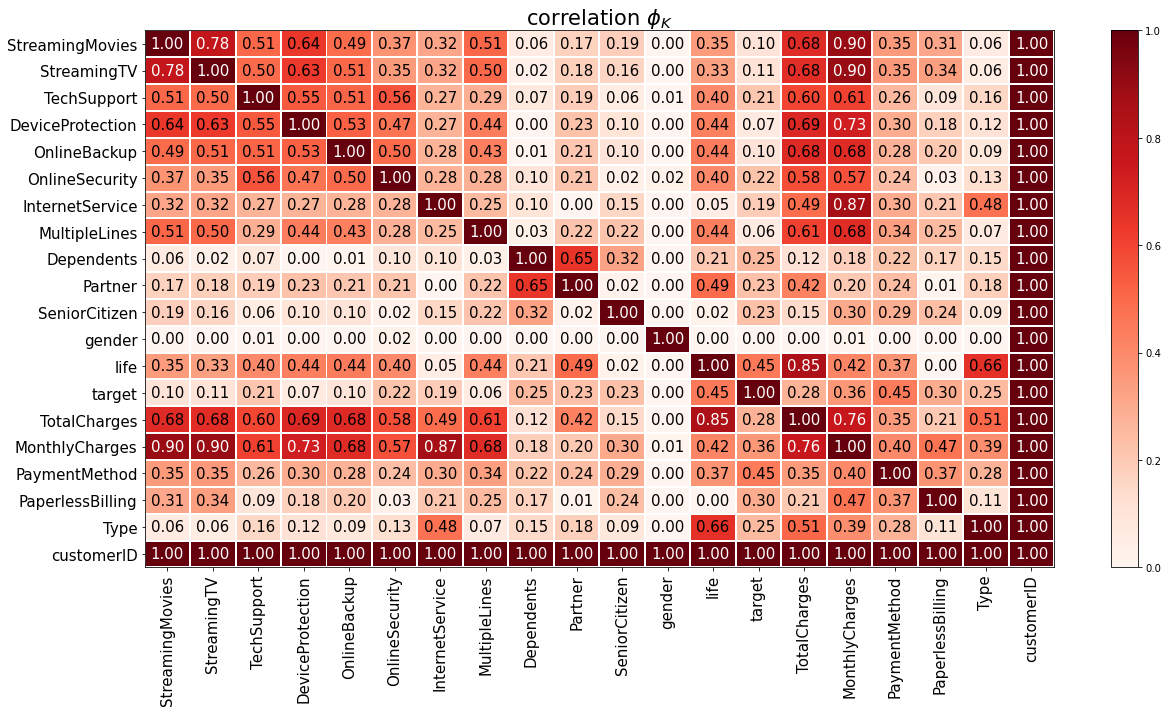

In [18]:
#проверка признаков на мультиколлинеарность
phik_overview = data_ultimate.phik_matrix()
phik_overview.round(2)
interval_cols = ['MonthlyCharges', 'TotalCharges', 'target', 'life', 'SeniorCitizen']
phik_overview = data_ultimate.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(18, 10))
plt.tight_layout()

**Как видно из таблицы выше следует удалить колонки StreamingTV,StreamingMovies,DeviceProtection,InternetService и TotalCharges которые сильно коррелируется с колонкой life .Так же будет удалена колонка customerID так как для обучения моделей она не понадобиться.**

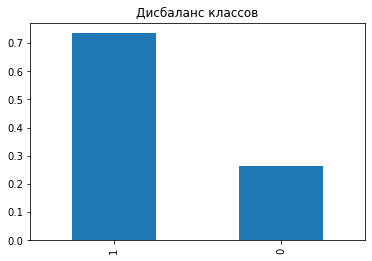

In [19]:
#выяление дисбаланса классов в колонке Target
test = data_ultimate['target'].value_counts(normalize=True).plot(kind='bar')
test.set_title("Дисбаланс классов");

In [20]:
data_ultimate['target'].value_counts(normalize=True)

1    0.73463
0    0.26537
Name: target, dtype: float64

**В данном случае мы можем наблюдать высокий дисбаланс классов который нужно будет учесть при построении модели.**

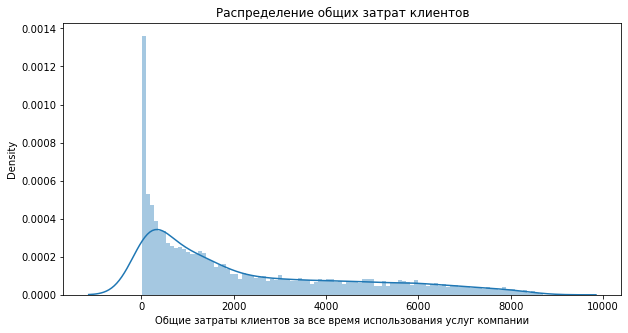

In [21]:
plt.figure(figsize=(10,5))
sns.distplot(data_ultimate['TotalCharges'], bins=100)
plt.title('Распределение общих затрат клиентов')
plt.xlabel('Общие затраты клиентов за все время использования услуг компании');

In [22]:
data_ultimate['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

**В среднем клиенты тратят 2283 у.е за все время.Медианное значение затрат 1397 у.е.**

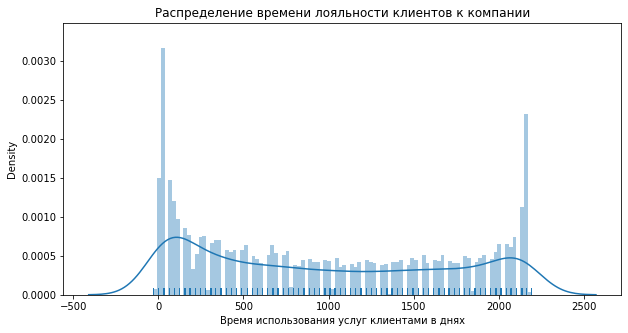

In [23]:
plt.figure(figsize=(10,5))
sns.distplot(data_ultimate['life'], bins=100,rug=True,)
plt.title('Распределение времени лояльности клиентов к компании')
plt.xlabel('Время использования услуг клиентами в днях');

In [24]:
data_ultimate['life'].describe()

count    7043.000000
mean      963.957263
std       743.019445
min       -30.000000
25%       246.000000
50%       853.000000
75%      1675.000000
max      2191.000000
Name: life, dtype: float64

**В среднем клиенты остаются лояльными к компании 963 дня**

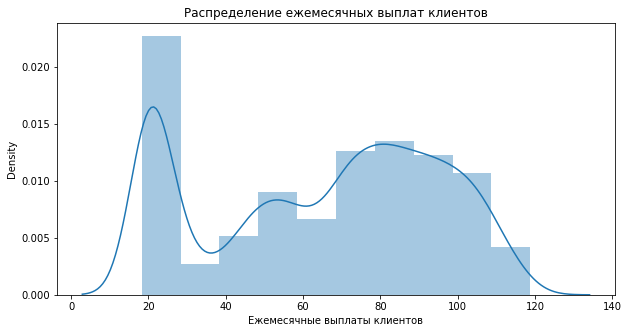

In [25]:
plt.figure(figsize=(10,5))
sns.distplot(data_ultimate['MonthlyCharges'], bins=10)
plt.title('Распределение ежемесячных выплат клиентов')
plt.xlabel('Ежемесячные выплаты клиентов');

In [26]:
data_ultimate['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

**Медианные ежемесячные затраты клиентов составляют 70 у.е**

**В данных наблюдается большой дисбаланс классов.Так же есть странное распределение значений в колонке ежемесячных выплат**

## Разбиение данных на выборки//Подбор модели и обучение

In [27]:
#создание функции downsample для уменьшения преобладающего класса в выборке
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled        

In [28]:
#удаление лишних колонок из датасета
data_ultimate = data_ultimate.drop(columns = ['InternetService', 'StreamingTV','customerID',
                                             'StreamingMovies','DeviceProtection','Type','TotalCharges'], axis = 1)
#кодирование датасета для модели случайного леса
data_ohe = pd.get_dummies(data=data_ultimate,drop_first=True)
data_ohe.head()

,MonthlyCharges,target,life,SeniorCitizen,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,TechSupport_Yes
0,29.85,1,1,0,1,0,1,0,0,1,0,0,0,0,0
1,56.95,1,1006,0,0,0,0,1,1,0,0,0,1,0,0
2,53.85,0,61,0,1,0,0,1,1,0,0,0,1,1,0
3,42.30,1,1341,0,0,0,0,0,1,0,0,0,0,0,0
4,70.70,0,61,0,1,0,1,0,0,0,0,0,0,0,0


In [29]:
data_ohe.isna().sum()

MonthlyCharges                           0
target                                   0
life                                     0
SeniorCitizen                            0
PaperlessBilling_Yes                     0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
MultipleLines_Yes                        0
OnlineSecurity_Yes                       0
OnlineBackup_Yes                         0
TechSupport_Yes                          0
dtype: int64

In [30]:
target = data_ohe['target']
features = data_ohe.drop(['target'] , axis=1)
features_train, features_valid,target_train, target_valid = train_test_split(
    features, target, test_size=0.3, random_state=12345,stratify=target)
features_valid,features_test,target_valid,target_test = train_test_split(
    features_valid,target_valid,test_size=0.5,random_state=12345,stratify=target_valid)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3) 

#### Модель случайного леса

In [31]:
model_Forest = RandomForestClassifier(random_state=12345,max_depth=6,n_estimators=10,
                                      class_weight='balanced').fit(features_downsampled, target_downsampled)
predictions_Forest = model_Forest.predict(features_valid)
probabilities_valid_Forest = model_Forest.predict_proba(features_valid)
auc_roc_Forest = roc_auc_score(target_valid,probabilities_valid_Forest[:, 1])
accuracy_Forest = accuracy_score(target_valid,predictions_Forest)
print('Значение AUC ROC для модели случайного леса:',auc_roc_Forest)
print('Значение ACCURCY для модели случайного леса:',accuracy_Forest)

Значение AUC ROC для модели случайного леса: 0.8065767673048602
Значение ACCURCY для модели случайного леса: 0.7642045454545454


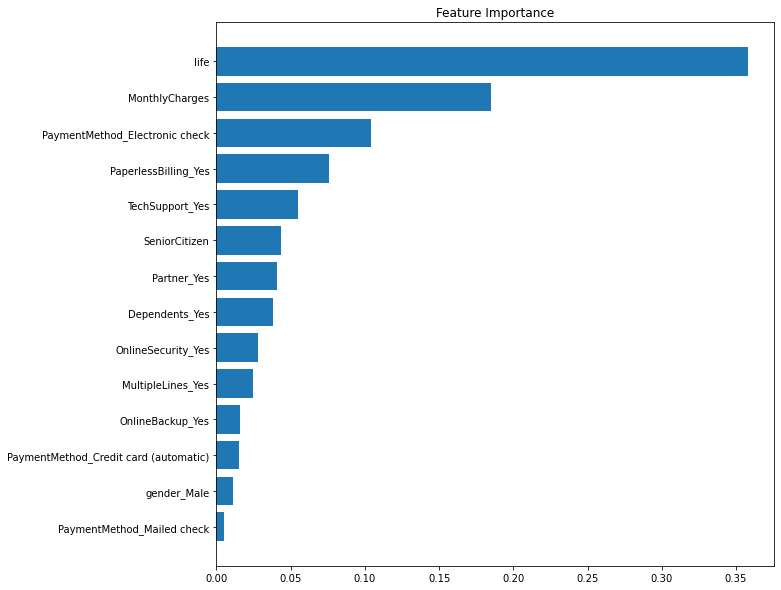

In [32]:
sort = model_Forest.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(features_downsampled.columns[sort], model_Forest.feature_importances_[sort])
plt.title("Feature Importance");

**В модели задан параметр class_weight='balanced' для дополнительной балансировки классов.На данном этапе модель не показывает нужные результаты,постараюсь улучшить модель с помощью GridSearchCV.**

**Так же был выведен график важности факторов,жизненный цикл клиента в компании и ежемесячные траты являются важнейшими факторами для модели леса**

In [33]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_model_Forest = GridSearchCV(estimator=model_Forest, param_grid=param_grid, cv= 5)
CV_model_Forest.fit(features_downsampled, target_downsampled)
CV_model_Forest.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [34]:
%%time
model_Forest = RandomForestClassifier(random_state=12345,max_depth=8,n_estimators=500,max_features ='auto',criterion='gini',
                                      class_weight='balanced').fit(features_downsampled, target_downsampled)
predictions_Forest = model_Forest.predict(features_valid)
probabilities_valid_Forest = model_Forest.predict_proba(features_valid)
auc_roc_Forest = roc_auc_score(target_valid,probabilities_valid_Forest[:, 1])
accuracy_Forest = accuracy_score(target_valid,predictions_Forest)
print('Значение AUC ROC для модели случайного леса:',auc_roc_Forest)
print('Значение ACCURCY для модели случайного леса:',accuracy_Forest)

Значение AUC ROC для модели случайного леса: 0.8191872238586155
Значение ACCURCY для модели случайного леса: 0.7954545454545454
Wall time: 1.12 s


**После подбора гиперпараметров значение AUC ROC увеличилось более чем на одну десятую, а значение ACCURCY выросло на 0.3**

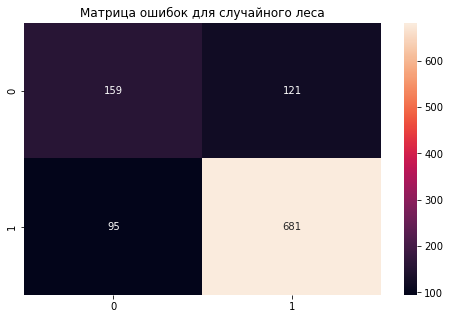

In [35]:
confusion_matrix_tree = confusion_matrix(target_valid,predictions_Forest)
plt.figure(figsize = (8,5))
sns.heatmap(confusion_matrix_tree, annot=True,fmt="d");
plt.title('Матрица ошибок для случайного леса');

**Как видно из матрицы ошибок значение TP=159,значение TN=681,FN=95 а FP=121.Вероятность того что модель предскажет уход клиенту который уходить не собирается высока**

#### Модель LGBM

In [36]:
#разбиение данных на выборки
target_LGBM = data_ultimate['target']
features_LGBM = data_ultimate.drop(['target'] , axis=1)
features_train_LGBM, features_valid_LGBM,target_train_LGBM, target_valid_LGBM = train_test_split(
    features_LGBM, target_LGBM, test_size=0.3, random_state=12345,stratify=target_LGBM)
features_valid_LGBM,features_test_LGBM,target_valid_LGBM,target_test_LGBM = train_test_split(
    features_valid_LGBM,target_valid_LGBM,test_size=0.5,random_state=12345,stratify=target_valid_LGBM)
#приведение колонок к нужному формату
LGBM_features_train = list(features_train_LGBM.select_dtypes(include=['object']).columns)
for i in LGBM_features_train:
    features_train_LGBM[i] = features_train_LGBM[i].astype('category')
    
LGBM_features_valid = list(features_valid_LGBM.select_dtypes(include=['object']).columns)
for i in LGBM_features_valid:
    features_valid_LGBM[i] = features_valid_LGBM[i].astype('category')
    
LGBM_features_test = list(features_test_LGBM.select_dtypes(include=['object']).columns)
for i in LGBM_features_test:
    features_test_LGBM[i] = features_test_LGBM[i].astype('category')

features_downsampled_LGBM, target_downsampled_LGBM = downsample(features_train_LGBM, target_train_LGBM, 0.3)

In [37]:
model_LGBM = LGBMClassifier(num_leaves=10).fit(features_downsampled_LGBM, target_downsampled_LGBM)
predictions_LGBM = model_LGBM.predict(features_valid_LGBM)
probabilities_valid_LGBM = model_LGBM.predict_proba(features_valid_LGBM)
auc_roc_LGBM = roc_auc_score(target_valid_LGBM,probabilities_valid_LGBM[:, 1])
accuracy_LGBM = accuracy_score(target_valid,predictions_LGBM)
print('Значение AUC ROC для модели LGBM',auc_roc_LGBM)
print('Значение ACCURCY для модели LGBM:',accuracy_LGBM)

Значение AUC ROC для модели LGBM 0.8977701583210604
Значение ACCURCY для модели LGBM: 0.8664772727272727


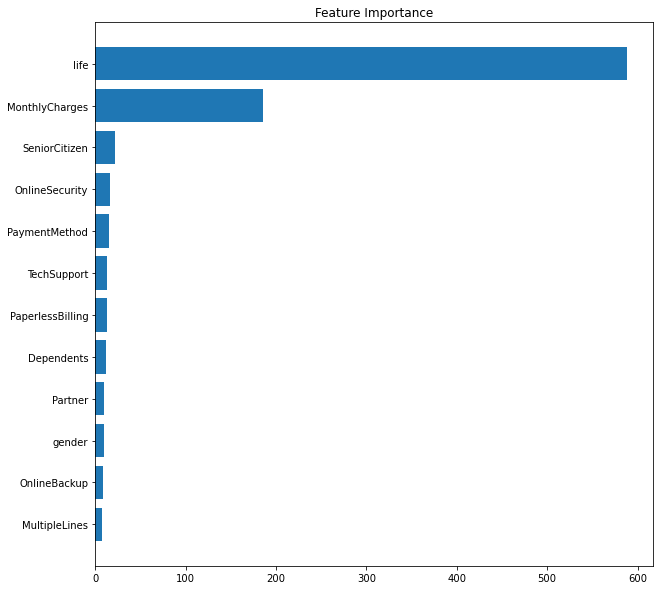

In [38]:
sort = model_LGBM.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(features_downsampled_LGBM.columns[sort], model_LGBM.feature_importances_[sort])
plt.title("Feature Importance");

**Как видно из графика выше для модели LGBM тоже важны признаки life и MonthlyCharges.Но остальные 'фичи' влияют на данную модель намного меньше чем на предидущую**

In [39]:
param_grid = { 
    'num_leaves': [5, 100],
    'max_depth' : [4,5,6,7,8,9,10],
    'n_estimators': [200, 500]
}
CV_model_LGBM = GridSearchCV(estimator=model_LGBM, param_grid=param_grid, cv= 5)
CV_model_LGBM.fit(features_downsampled_LGBM, target_downsampled_LGBM)
CV_model_LGBM.best_params_

{'max_depth': 4, 'n_estimators': 500, 'num_leaves': 5}

In [40]:
%%time
model_LGBM = LGBMClassifier(max_depth=4,num_leaves=100,
                            n_estimators=500).fit(features_downsampled_LGBM, target_downsampled_LGBM)
predictions_LGBM = model_LGBM.predict(features_valid_LGBM)
probabilities_valid_LGBM = model_LGBM.predict_proba(features_valid_LGBM)
auc_roc_LGBM = roc_auc_score(target_valid_LGBM,probabilities_valid_LGBM[:, 1])
accuracy_LGBM = accuracy_score(target_valid_LGBM,predictions_LGBM)
print('Значение AUC ROC для модели LGBM',auc_roc_LGBM)
print('Значение ACCURCY для модели LGBM:',accuracy_LGBM)

Значение AUC ROC для модели LGBM 0.9327089469808543
Значение ACCURCY для модели LGBM: 0.9024621212121212
Wall time: 147 ms


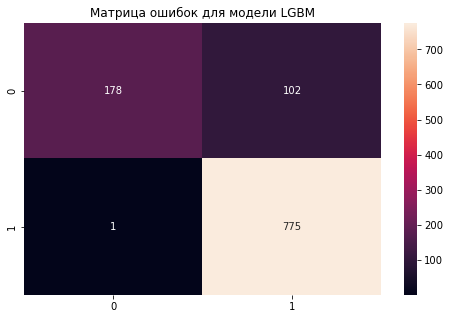

In [41]:
confusion_matrix_tree = confusion_matrix(target_valid_LGBM,predictions_LGBM)
plt.figure(figsize = (8,5))
sns.heatmap(confusion_matrix_tree, annot=True,fmt="d");
plt.title('Матрица ошибок для модели LGBM');

**После обучения и подбора параметров модель показывает хорошие рузультаты.Значение FN и FP тоже не высокие.Вероятность того что модель предскажет уход клиенту который не собирается покидать компанию ниже чем у модели случайного леса.**

#### Модель CatBoost

**Для эксперемента буду использовать модель CatBoostClassifier**

In [42]:
target_cat = data_ultimate['target']
features_cat = data_ultimate.drop(['target'] , axis=1)

features_train1, features_valid1,target_train1, target_valid1 = train_test_split(
    features_cat, target_cat, test_size=0.3, random_state=12345,stratify=target_cat)

features_valid1,features_test1,target_valid1,target_test1 = train_test_split(
    features_valid1,target_valid1,test_size=0.5,random_state=12345,stratify=target_valid1)

cat_features = ['PaperlessBilling','PaymentMethod','gender','Partner','Dependents',
               'MultipleLines','OnlineSecurity','OnlineBackup',
               'TechSupport']
features_downsampled_CAT, target_downsampled_CAT = downsample(features_train1, target_train1, 0.3)
data_ultimate.head()

,PaperlessBilling,PaymentMethod,MonthlyCharges,target,life,gender,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,TechSupport
0,Yes,Electronic check,29.85,1,1,Female,0,Yes,No,No,No,No,No
1,No,Mailed check,56.95,1,1006,Male,0,No,No,No,Yes,No,No
2,Yes,Mailed check,53.85,0,61,Male,0,No,No,No,Yes,Yes,No
3,No,Bank transfer (automatic),42.30,1,1341,Male,0,No,No,No,No,No,No
4,Yes,Electronic check,70.70,0,61,Female,0,No,No,No,No,No,No


In [43]:
%%time
best_params = {
    'bagging_temperature': 0.5,
    'depth': 8,
    'iterations': 1000,
    'l2_leaf_reg': 25,
    'learning_rate': 0.05,
    'sampling_frequency': 'PerTreeLevel',
    'leaf_estimation_method': 'Gradient',
    'random_strength': 0.8,
    'boosting_type': 'Ordered',
    'feature_border_type': 'MaxLogSum',
    'l2_leaf_reg': 50,
    'max_ctr_complexity': 2,
    'fold_len_multiplier': 2
}
    
model_Cat = CatBoostClassifier(**best_params,
                               loss_function='Logloss',
                               eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=True)



model_Cat.fit(features_downsampled_CAT, target_downsampled_CAT,
              eval_set=(features_valid1, target_valid1),
              cat_features=cat_features,
              verbose_eval=300,
              early_stopping_rounds=500,
              use_best_model=True,
              plot=False)

predictions_Cat = model_Cat.predict(features_valid1)
probabilities_valid_Cat = model_Cat.predict_proba(features_valid1)
auc_roc_Cat = roc_auc_score(target_valid1,probabilities_valid_Cat[:, 1])
accuracy_Cat = accuracy_score(target_valid1,predictions_Cat)
print('Значение AUC ROC для модели CatBoost:',auc_roc_Cat)
print('Значение ACCURCY для модели CatBoost:',accuracy_Cat)

0:	test: 0.7670655	best: 0.7670655 (0)	total: 173ms	remaining: 2m 52s
300:	test: 0.9057115	best: 0.9057115 (300)	total: 7.15s	remaining: 16.6s
600:	test: 0.9336616	best: 0.9336616 (600)	total: 16.8s	remaining: 11.1s
900:	test: 0.9418630	best: 0.9418630 (900)	total: 26.4s	remaining: 2.91s
999:	test: 0.9432714	best: 0.9432714 (999)	total: 29.6s	remaining: 0us

bestTest = 0.9432713549
bestIteration = 999

Значение AUC ROC для модели CatBoost: 0.943271354933726
Значение ACCURCY для модели CatBoost: 0.9024621212121212
Wall time: 29.9 s


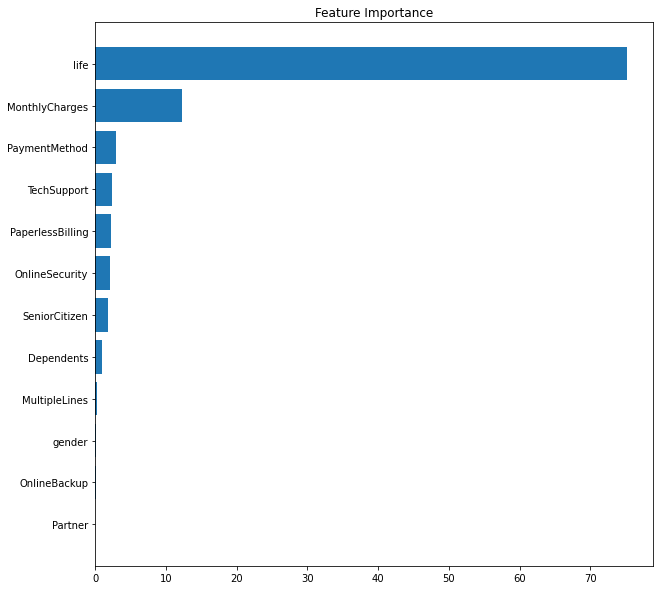

In [44]:
sort = model_Cat.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(features_downsampled_CAT.columns[sort], model_Cat.feature_importances_[sort])
plt.title("Feature Importance");

**По важности признаков у модели CatBoost схожая с LGBM картина.Явно выделяются два основных признака,остальные менее важны**

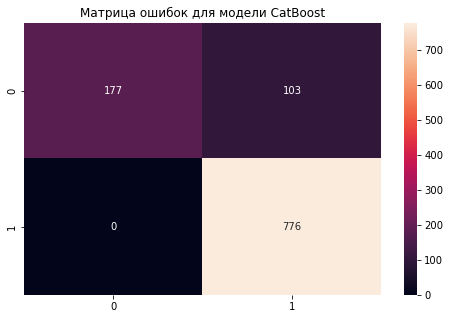

In [45]:
confusion_matrix_tree = confusion_matrix(target_valid1,predictions_Cat)
plt.figure(figsize = (8,5))
sns.heatmap(confusion_matrix_tree, annot=True,fmt="d");
plt.title('Матрица ошибок для модели CatBoost');

**Модель так же показывает отличные результаты но обучается значительно дольше.Значения FN и FP не сильно отличаются от LGBM.**

In [46]:
final_data = pd.DataFrame({'test':['Значение AUC ROC','Значение ACCURCY','Время обучения'],
                         'RandomForestClassifier':[auc_roc_Forest,accuracy_Forest,'1.14 s'],
                         'LGBMClassifier':[auc_roc_LGBM,accuracy_LGBM,'155 ms'],
                         'CatBoostClassifier':[auc_roc_Cat,accuracy_Cat,'29.1 s']
                         })
final_data

,test,RandomForestClassifier,LGBMClassifier,CatBoostClassifier
0,Значение AUC ROC,0.819187,0.932709,0.943271
1,Значение ACCURCY,0.795455,0.902462,0.902462
2,Время обучения,1.14 s,155 ms,29.1 s


**Для финального тестирования мною была выбрана модель LGBM которая показала самые высокие результаты на валидационной выборке.Модель CatBoost так же хорошо себя зарекомендовала ,причем сделала она это на дефолтных настройках,но для финального теста данная модель не была рекомендована преподавателями**

**В таблице final_data приведены все результаты моделей которые они показали на валидационной выборке**

## Тестирование модели

In [47]:
%%time
predictions_LGBM = model_LGBM.predict(features_test_LGBM)
probabilities_valid_LGBM = model_LGBM.predict_proba(features_test_LGBM)
auc_roc_LGBM = roc_auc_score(target_test_LGBM,probabilities_valid_LGBM[:, 1])
accuracy_LGBM = accuracy_score(target_test_LGBM,predictions_LGBM)
print('Значение AUC ROC для модели LGBM',auc_roc_LGBM)
print('Значение ACCURCY для модели LGBM:',accuracy_LGBM)

Значение AUC ROC для модели LGBM 0.9451654620831347
Значение ACCURCY для модели LGBM: 0.9044465468306528
Wall time: 33.3 ms


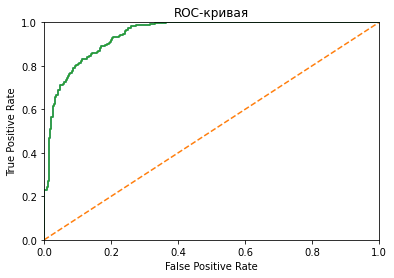

In [48]:
probabilities_one_valid = probabilities_valid_LGBM[:, 1]

fpr, tpr, thresholds = roc_curve(target_test_LGBM,probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Вывод

**В финальном тестировании модель показала результат AUC ROC 0.945 и ACCURCY 0.904 что удовлетворяет условиям задачи.При этом модель не переобучилась**

**Но вероятность того что модель предскажет уход клиентам которые уходить не собираются все же остается,поэтому я бы предложил клиентам которые собираются уходить единаразовую скидку из учета их ежемесячных трат.Напомню что в медианные затраты клиента в месяц 70 у.е.**